## Identifying Ionized Bubbles in HERA Observations Using a U-net Deep Learning Network
This demo illustrates the segmentation of cosmological images observed by a radio telescope through a $\texttt{U-net}$ deep learning network. Convolutional neural networks (CNNs) are typically used for classification tasks, where the output for an image is a single class label. However,  the growing application of deep learning in visual tasks has highlighted the importance of pixel-wise class labeling for tasks like localization and segmentation. Then why is this technique significant in astrophysics? Identifying objects in the distant universe and extracting their topological information offers a unique perspective on the formation and evolution of galaxies, and this is where deep learning networks can play a crucial role.

### Brief background on the astrophysical goal
In the realm of modern astrophysics and cosmology,  a fascinating yet challenging pursuit includes the detection of signals emanating from neutral hydrogen in the early, and therefore distant, universe. The characteristics of this neutral hydrogen hold particular interest, as they offer valuable insights into unraveling the evolutionary history of the early universe.

During the early phases of the universe, the abundant neutral hydrogen gas experiences a phase transition from a neutral to an ionized state with the emergence of the first stars and galaxies. This transition gives rise to the formation of ionized bubbles, denoted as HII bubbles in Figure 1. This study specifically aims to investigate the tomography of neutral hydrogen by mapping the period in the universe when these ionized bubbles come into existence (i.e., localization/segmetation of the cosmological objects).

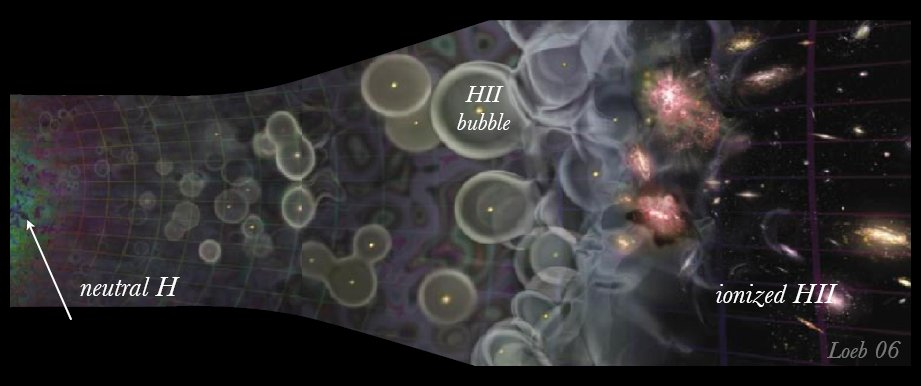

$\textbf{[Figure 1]}$ Evolutionary history from early universe (far left) to today (far right). Our interest is the tomography of neutral hydrogen associated with ionized bubbles. Image credit: Leob 2006

### Deep learning technique for segmentation
One of the powerful tools for pixel-wise classification is [$\texttt{U-net}$](https://arxiv.org/abs/1505.04597), proposed by Ronneberger et al. (2015) for sementation of biomedical images. This deep learning network consists of two branches, an encoding path and a decoding path, which enable precise localization for pixel-wise classification. This architecture has been further employed in various fields, including astrophysics. By using the $\texttt{U-net}$, for example, Bianco et al. (2021) forecasts the tomography of neutral hydrogen with future and high-spec radio instrument. We adopt a similar strategy but with the mock observations with our current instrument, Hydrogen Epoch of Reionization Array ([$\textbf{HERA}$](https://reionization.org/)).

Figure 2 depicts the diagram of $\texttt{U-net}$ structure. It follows the standard $\texttt{U-net}$ structure, comprising an $\textbf{encoding}$ (downsampling) path and a $\textbf{decoding}$ (upsampling) path. The encoding path consists of four consecutive downsampling blocks, each utilizing a combination of 2D convolutions, batch normalization, and ReLU activation twice, aiming to extract semantic features at each convolution layer. The downsampling is achieved through max-pooling operations. The decoding path, symmetric to the encoding path, involves four upsampling blocks that restore the dimensions of input feature maps. The upsampling is performed using bilinear interpolation. Each upsampling block is followed by a $\textbf{concatenation}$ operation with the corresponding feature maps from the encoding path and a double convolution block, maintaining spatial information. The network closes with a 1x1 convolutional layer and sigmoid activation in the output layer.

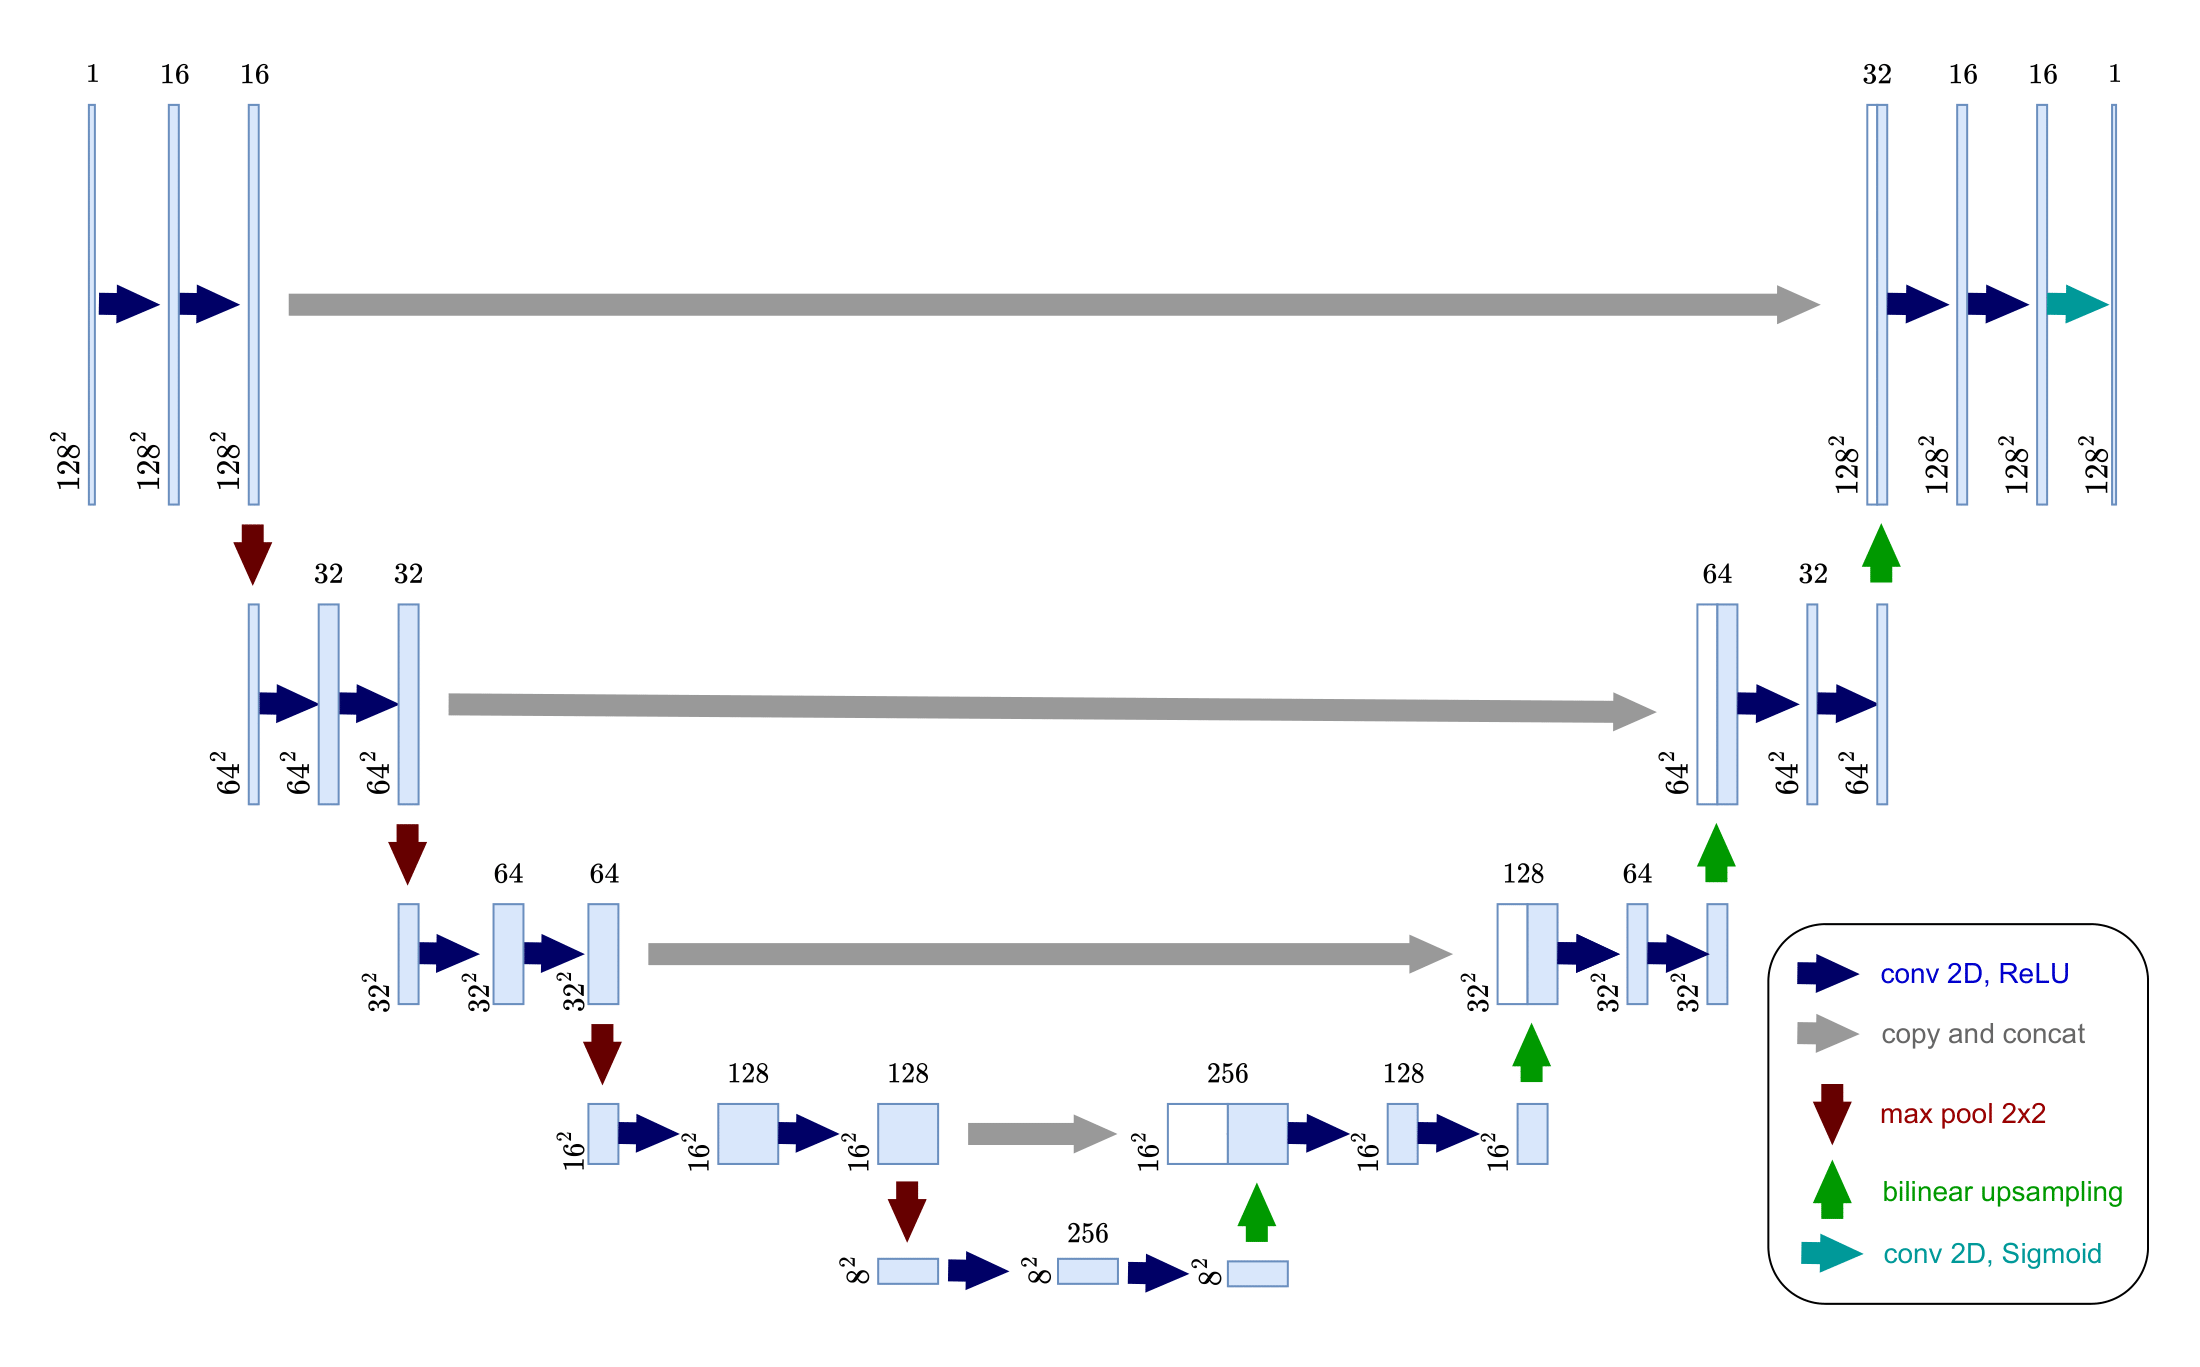

$\textbf{[Figure 2]}$ CNN $\texttt{U-net}$ architecture (U-shape), consisting of encoding and decoding branches with double CNN operations at each layer. $\texttt{U-net}$ introduces skip connections between corresponding layers in the encoder and decoder. These connections pass feature maps from the encoder directly to the decoder, which helps in recovering fine details lost during the downsampling process in the encoder. This results in more precise segmentation.

The network is optimized by minimizing a loss function, which is combined by the $\textbf{Balanced Cross-Entropy (BCE) loss}$ and $\textbf{Dice loss}$: Loss = $L_{\rm CE} + L_{\rm dice}$.

The Cross-Entropy (CE) Loss function is widely used in classification tasks, which quantifies the performance of a classification model whose output is a probability value between 0 and 1. The BCE loss is a variation of the standard CE loss function that is particularly useful when dealing with imbalanced datasets in binary classification tasks by giving more importance (higher weight) to the negative (minority) class. This follows as $L_{\rm CE}(y, \hat{y}) = -[\alpha y \log(\hat{y}) + (1-\alpha) (1 - y) \log(1 - \hat{y})]$ where $\alpha$ is the weight for the positive class, $y$ and $\hat{y}$ are ground truth and prediction, respectively. This BCE loss function can be particularly important for our task because our data includes various states from fully neutral (0) to fully ionized (1) maps where minority cases may occur.

The Dice loss is a measure of the similarity between two sets, assessing the overlap between predicted and true segmentation masks. Explicitly, it can be computed as follows: $L_{\rm dice} = 1 - \frac{2 \cdot |Y \cap \hat{Y}|}{|Y| + |\hat{Y}|}$ where $Y$ and $\hat{Y}$ indicate the set of ground truth and prediction, respectively. $|\cdot|$ denotes the number of elements.

A combination of BCE loss and dice loss is used to account for both pixel-wise classification accuracy (cross-entropy) and segmentation mask similarity (dice loss). We see an improvement between the BCE alone and the combined loss function, though it is marginal (from 0.86 to 0.88 in accuracy).

### Training and Test samples
To generate training samples, I used simulated data from the 21cmFAST software (Mesinger et al., 2011), a tool for simulating the hydrogen brightness temperature. This simulator also produces binary maps of neutral states, which serve as our ground truth. A total of 1,000 simulations were created by varying cosmological model parameters, and the dataset was further expanded through augmentations like rotations and translations, resulting in around 140K samples. The brightness temperature maps were then degraded to match the resolution of our instrument.

Figure 3 displays a 2D brightness temperature map at the simulation resolution (left) alongside its degraded version (middle), which serves as our input data. Due to the instrument's limited resolution in capturing small-scale features, the ground truth maps at simulation resolution are similarly degraded, as illustrated in the right panel. This is one example from approximately 140K samples.

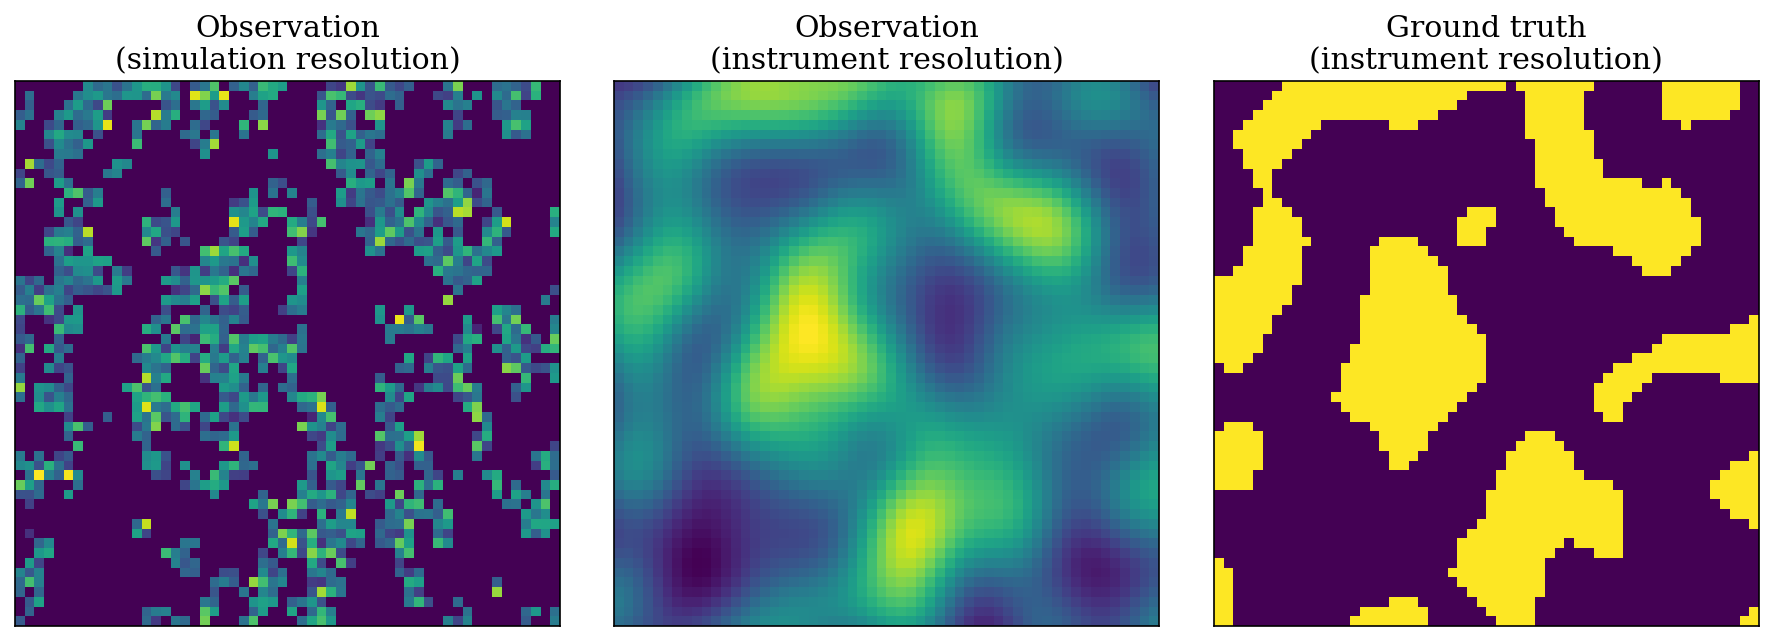

In [1]:
from data import DATA_PATH
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
plt.rc('font', family='serif', size=12)

dir_img = DATA_PATH['img_parent']
dir_img_sim = DATA_PATH['img_sim_parent']
dir_mask = DATA_PATH['mask_parent']

data_dic = {}
file = glob.glob(os.path.join(dir_img_sim, "model0007_038_slice026.npy"))[0]
data_dic['img_sim'] = np.load(file)

file = glob.glob(os.path.join(dir_img, "model0007_038_slice026.npy"))[0]
data_dic['img'] = np.load(file)

file = glob.glob(os.path.join(dir_mask, "model0007_038_slice026_mask.npy"))[0]
data_dic['mask'] = np.load(file)

fig = plt.figure(figsize=(15,5), dpi=150)
ax = fig.add_subplot(1,3,1)
ax.imshow(data_dic['img_sim'][4:-4,4:-4])
ax.set_title('Observation\n(simulation resolution)')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1,3,2)
ax.imshow(data_dic['img'][4:-4,4:-4])
ax.set_title('Observation\n(instrument resolution)')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1,3,3)
ax.imshow(data_dic['mask'][4:-4,4:-4])
ax.set_title('Ground truth\n(instrument resolution)')
ax.set_xticks([])
ax.set_yticks([])

fig.subplots_adjust(wspace=0.1, hspace=0.3)

$\textbf{[Figure 3]}$ A set of examples for training samples. Left: brightness temperature observation at simulation resolution; Middle: brightness temperature observation at instrument resolution ($\textbf{input}$); Right: ground truth (neutral state; dark=0, bright=1) at instrument resolution ($\textbf{target}$). The observation at instrument resolution is derived from the simulation resolution by applying our instrument's point-spread-function (PSF), which serves as the input data. The ground truth at instrument resolution serve as the target data. Our objective is to segment the middle panel to predict the right panel.

### Code
Here's the code that demonstrates how we implement the $\texttt{U-net}$ for segmenting cosmological images. The implementation is based on the code from https://github.com/milesial/Pytorch-UNet.

In [2]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import logging
import wandb
import itertools

from unet.unet_parts import *
from utils.data_loading import BasicDataset, CarvanaDataset
from utils.dice_score import dice_loss
from evaluate import evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.rc('font', family='serif', size=18)

As depicted in Figure 2, the $\texttt{U-net}$ architecture consists of four downsampling blocks and four upsampling blocks. Each layer contains convolutional opertors, followed by batch normalization and ReLU activation, repeated twice and incorporates skip connections between corresponding layers. This operation is implemented in the $\texttt{Down}$ and $\texttt{Up}$ functions in the code provided below.

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32))
        self.down2 = (Down(32, 64))
        self.down3 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor))
        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32 // factor, bilinear))
        self.up4 = (Up(32, 16, bilinear))
        self.outc = (OutConv(16, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Device used for training is set. In this demo, we used GPU (NVIDIA A100 80GB PCIe).

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(f"Using device: {device} ({torch.cuda.current_device()})\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))
logging.info(f'Using device {device}')

Using device: cuda (0)	NVIDIA A100 80GB PCIe


Parameters that are used for model optimization are set, including the number of epochs, mini batch size, initial value and decay rate of the learning rate, and so on.

In [5]:
epochs = 5
batch_size = 512
learning_rate = 1e-5
val_percent = 0.1
save_checkpoint = True
bilinear = True
amp = True
weight_decay = 1e-8
momentum = 0.999
gradient_clipping = 1.0

We split 160K samples into 144K training samples and 16K validation samples and load the data into pyTorch DataLoader.

In [6]:
dir_img = DATA_PATH['img']
dir_mask = DATA_PATH['mask']
dir_checkpoint = DATA_PATH['checkpoint']

img_scale = 1
dataset = BasicDataset(dir_img, dir_mask, img_scale, mask_suffix='_mask')

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))
print(f"# of training samples: {n_train}\n# of validation samples: {n_val}")

loader_args = dict(batch_size=batch_size, num_workers=20, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

# of training samples: 144000
# of validation samples: 16000


In [7]:
# Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
model = UNet(n_channels=1, n_classes=1, bilinear=bilinear)
model = model.to()
model.to(device=device)
optimizer = optim.RMSprop(model.parameters(),
                          lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.BCEWithLogitsLoss()

Training the model iterating over 5 epoches. In each loop, the model updates the learning rate scheduler based on validation performance.

In [8]:
# Begin training
global_step = 0
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            assert images.shape[1] == model.n_channels, \
                f'Network has been defined with {model.n_channels} input channels, ' \
                f'but loaded images have {images.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

            with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                masks_pred = model(images)
                loss = criterion(masks_pred.squeeze(1), true_masks.float())
                loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix(**{'loss (batch)': loss.item()})

            # Evaluation round
            division_step = (n_train // (5 * batch_size))
            if division_step > 0:
                if global_step % division_step == 0:

                    val_score = evaluate(model, val_loader, device, amp)
                    scheduler.step(val_score)

                    logging.info('Validation Dice score: {}'.format(val_score))
                    try:
                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })
                    except:
                        pass

    if save_checkpoint:
        if not os.path.exists(dir_checkpoint):
            os.mkdir(dir_checkpoint)
        state_dict = model.state_dict()
        state_dict['mask_values'] = dataset.mask_values
        torch.save(state_dict, os.path.join(dir_checkpoint, 'checkpoint_epoch{}.pth'.format(epoch)))
        logging.info(f'Checkpoint {epoch} saved!')

Epoch 5/5: 100%|██████████| 144000/144000 [00:35<00:00, 4085.03img/s, loss (batch)=0.287] 


Here’s the structure of the first block of the encoder and total number of parameters:

In [9]:
model.down1

Down(
  (maxpool_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
)

In [10]:
total_params = sum(param.numel() for param in model.parameters())
print(f"total number of parameters: {total_params}")

total number of parameters: 1080641


### Prediction results for test samples
An example of the model's prediction compared to the ground truth is evaluated on separate test samples (). In Figure 4, the final panel is generated from the second panel using the trained model. Visual inspection reveals that the prediction closely matches the ground truth, with only minor differences. Figure 5 provides additional examples for the test samples, displaying brightness temperature observations (in viridis color maps) alongside the ground truth (black contours) and the model's predictions (orange contours). Overall, the predictions align well with the expected ground truth.

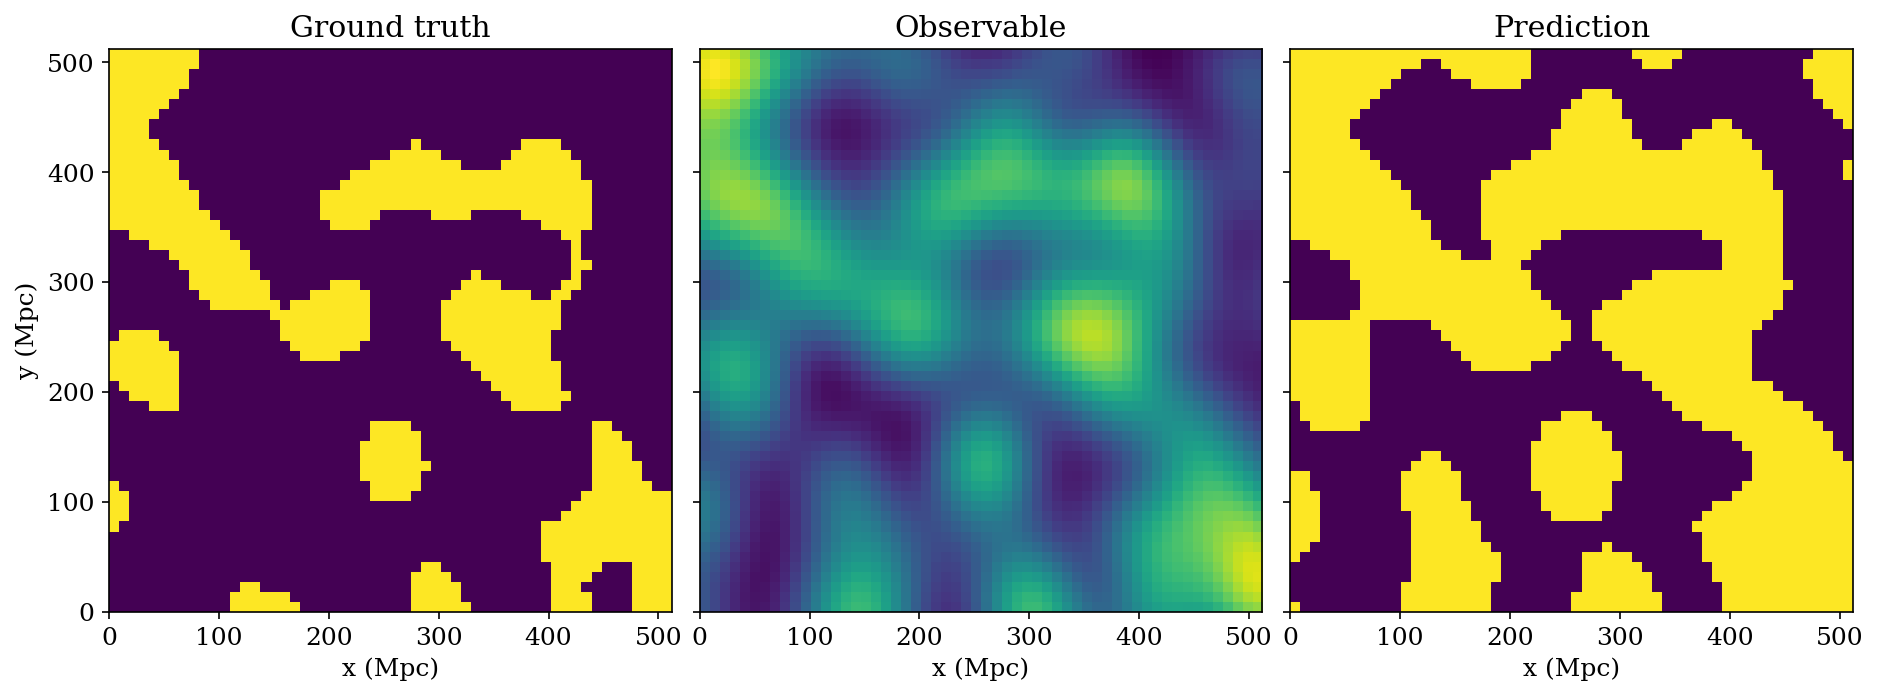

In [11]:
plt.rc('font', family='serif', size=12)
img_scale=1
loader_args = dict(batch_size=batch_size, num_workers=20, pin_memory=True)

dir_img_test = DATA_PATH['img_test']
dir_mask_test = DATA_PATH['mask_test']
test_loader = BasicDataset(dir_img_test, dir_mask_test, img_scale, mask_suffix='_mask')
test_loader = DataLoader(test_loader, shuffle=False, **loader_args)

batch = next(iter(test_loader))
images, true_masks = batch['image'], batch['mask']

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
mask_pred = model(images)

mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
        
i = 15

fig = plt.figure(figsize=(15,5), dpi=150)
ax = fig.add_subplot(1,3,1)
ax.imshow(true_masks[i][4:-4, 4:-4], extent=[0, 512, 0, 512])
ax.set_title('Ground truth')
ax.set_xlabel('x (Mpc)')
ax.set_ylabel('y (Mpc)')

image_ = images.squeeze(1)[i].cpu().detach().numpy()
ax = fig.add_subplot(1,3,2)
ax.imshow(image_[4:-4, 4:-4], extent=[0, 512, 0, 512])
ax.set_title('Observable')
ax.set_xlabel('x (Mpc)')
ax.set_yticklabels([])

mask_pred_ = mask_pred.squeeze(1)[i].cpu().detach().numpy()
ax = fig.add_subplot(1,3,3)
ax.imshow(mask_pred_[4:-4, 4:-4], extent=[0, 512, 0, 512])
ax.set_title('Prediction')
ax.set_xlabel('x (Mpc)')
ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.05)

$\textbf{[Figure 4]}$ An example of the prediction from the test samples using the trained model.

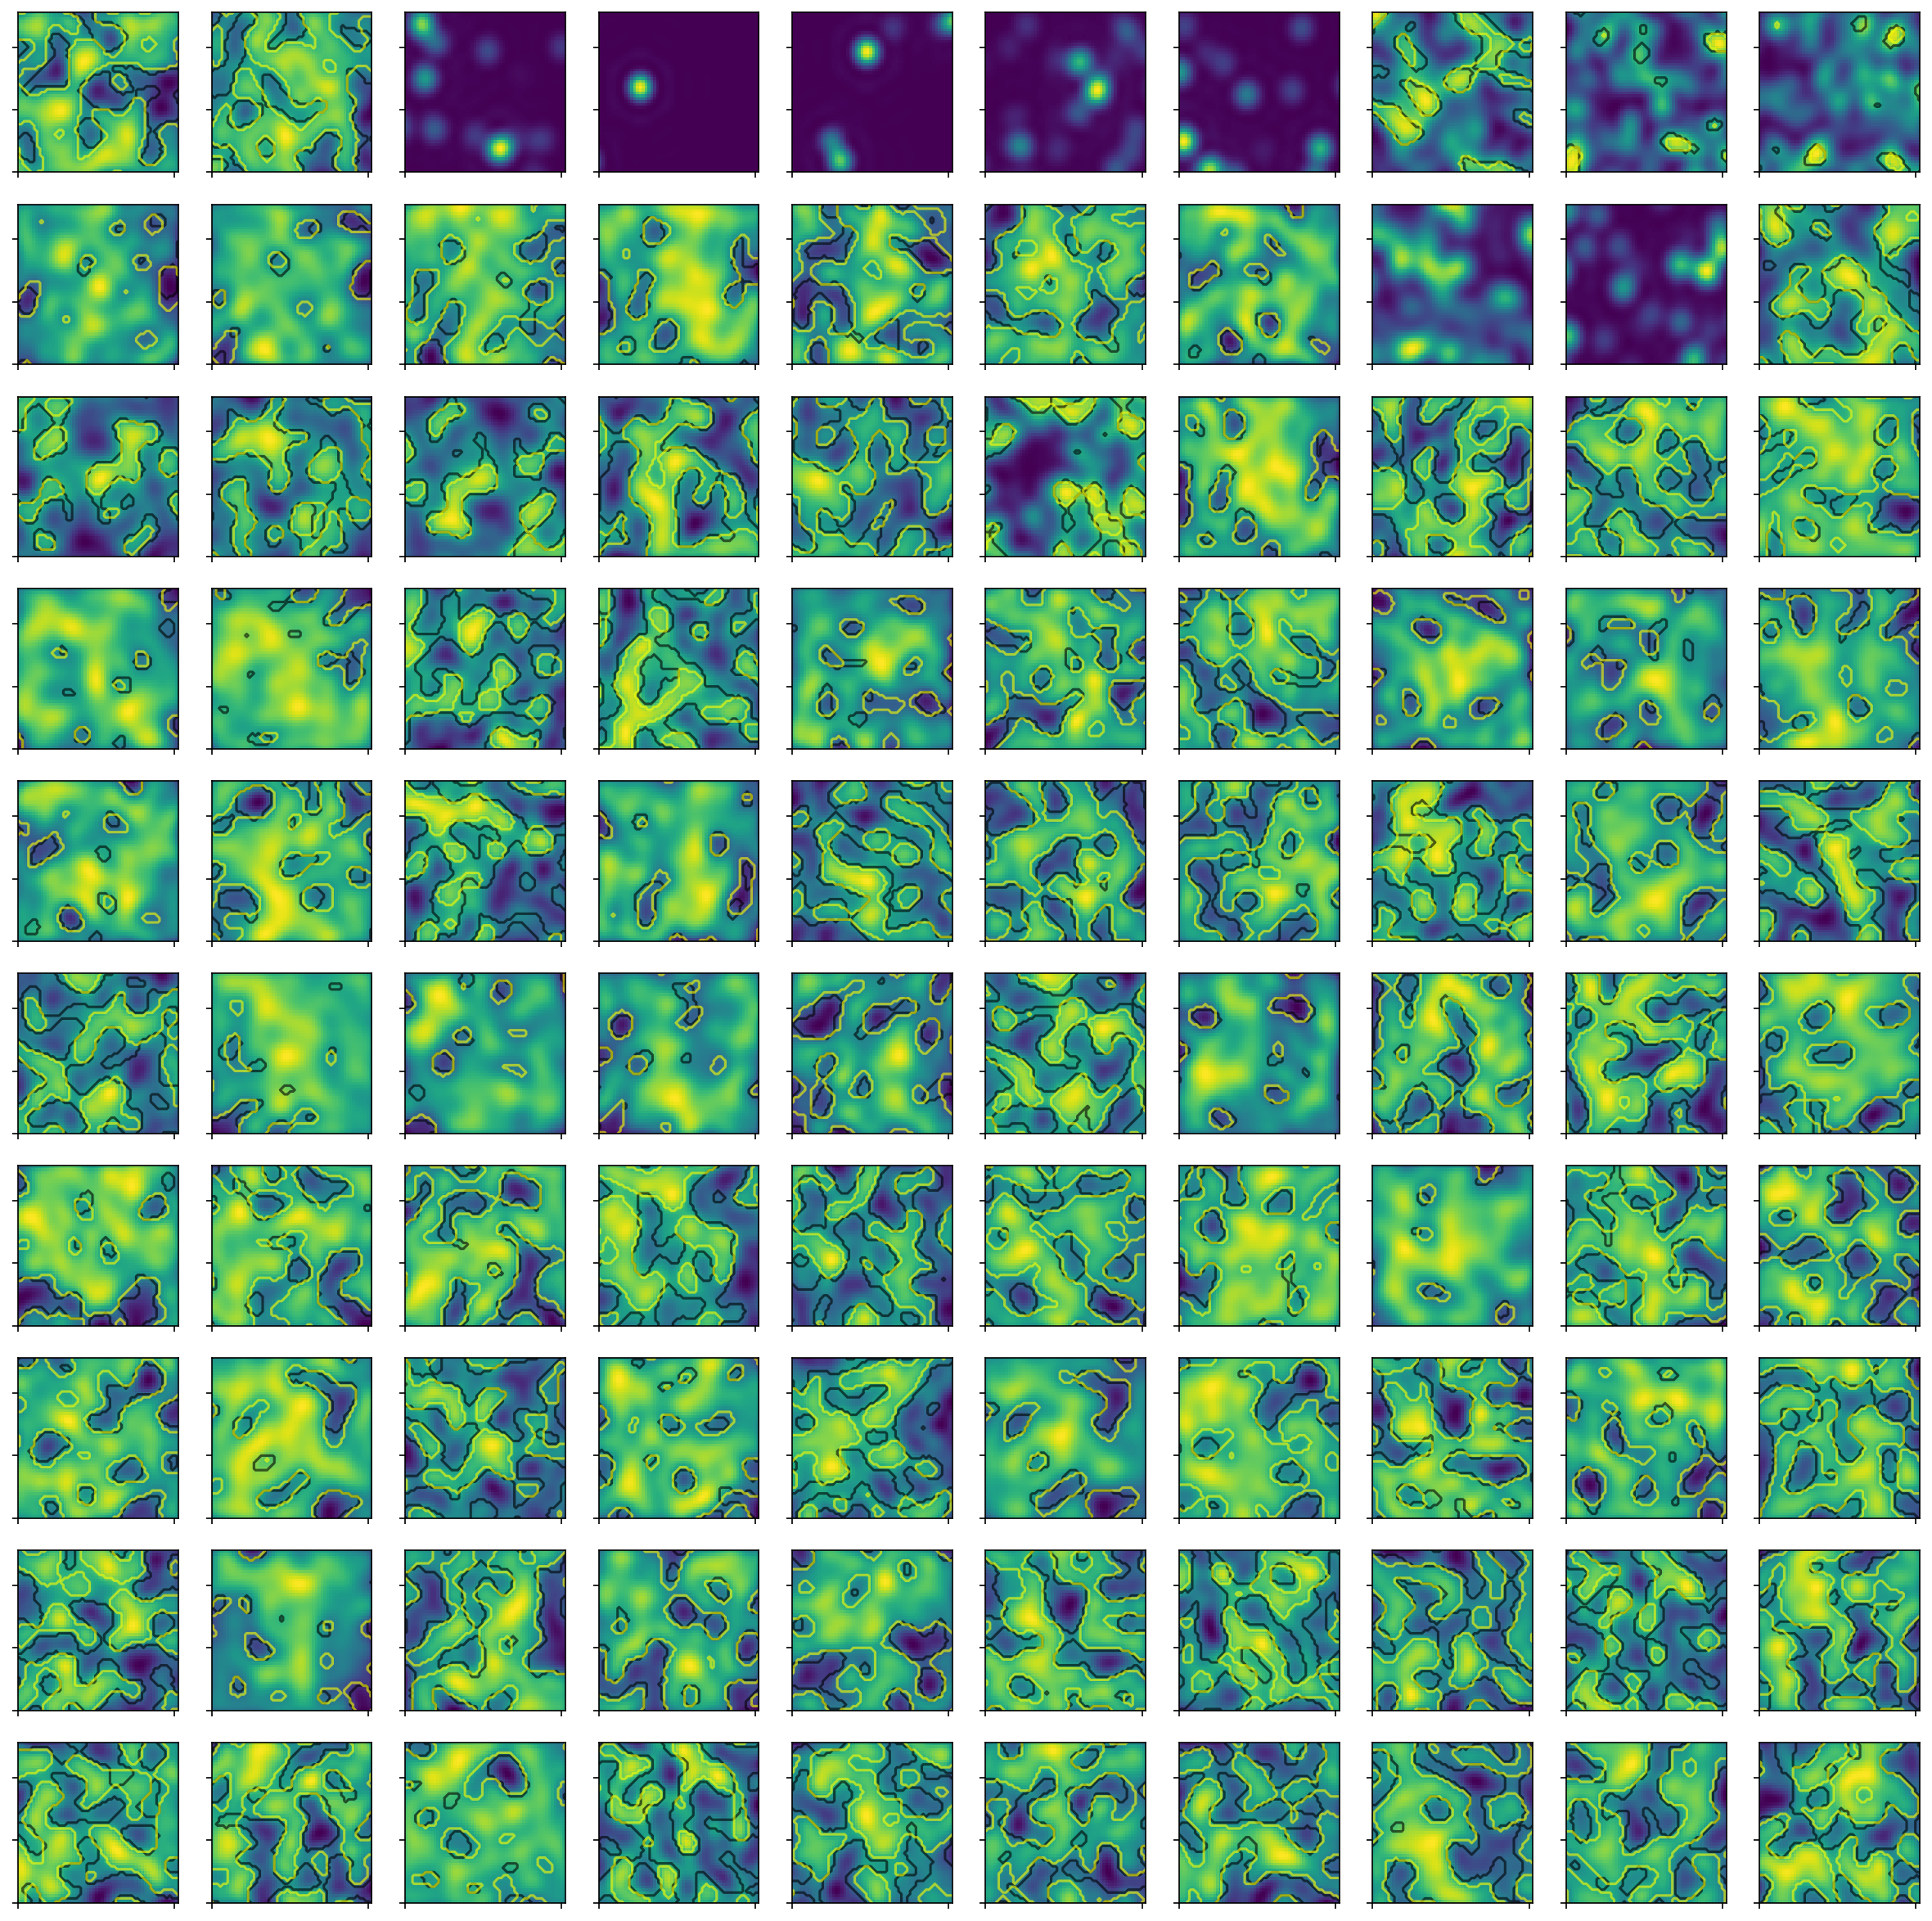

In [12]:
img_scale = 1
loader_args = dict(batch_size=batch_size, num_workers=20, pin_memory=True)
dir_img_test = DATA_PATH['img_test']
dir_mask_test = DATA_PATH['mask_test']
test_loader = BasicDataset(dir_img_test, dir_mask_test, img_scale, mask_suffix='_mask')
test_loader = DataLoader(test_loader, shuffle=False, **loader_args)

batch = next(itertools.islice(iter(test_loader), 1, 2))
images, true_masks = batch['image'], batch['mask']
    
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
mask_pred = model(images)

mask_pred = (F.sigmoid(mask_pred) > 0.5).float()

x = np.linspace(0, 512, true_masks[0][4:-4, 4:-4].shape[0])
y = np.linspace(0, 512, true_masks[0][4:-4, 4:-4].shape[1])
xx, yy = np.meshgrid(x, y, indexing='ij')

fig = plt.figure(figsize=(20,20), dpi=150)
for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    image_ = images.squeeze(1)[i].cpu().detach().numpy()
    ax.imshow(image_[4:-4, 4:-4], extent=[0, 512, 0, 512])
    ax.contour(xx, yy, true_masks[i].cpu().detach().numpy()[4:-4, 4:-4][::-1].T, levels=[0.5], colors=['black'], alpha=0.6)
    ax.contour(xx, yy, mask_pred.squeeze(1)[i].cpu().detach().numpy()[4:-4, 4:-4][::-1].T, levels=[0.5], colors=['yellow'], alpha=0.6)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

$\textbf{[Figure 5]}$ Predicted segmentation (orange contours) compared to the ground truth segmentation (black contours) for the test samples.

### Statistical assessment on the prediction
Now, let's assess how accurately the model predicts the ground truth. We used accuracy, precision, recall, and F1-score to evaluate its performance. All metrics exceeding 90% suggest that the trained model effectively and confidently predicts the ground truth segmentation.

In [13]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            images, targets = batch['image'], batch['mask']

            # Transfer data to the GPU if available
            images, targets = images.to(device), targets.to(device)

            # Forward pass
            predictions = model(images)

            # Collect predictions and targets for evaluation
            all_predictions.append(predictions.cpu().detach().numpy())
            all_targets.append(targets.cpu().detach().numpy())

    all_predictions = torch.from_numpy(np.concatenate(all_predictions, axis=0))
    all_targets = torch.from_numpy(np.concatenate(all_targets, axis=0))

    return all_predictions, all_targets

In [14]:
img_scale = 1
loader_args = dict(batch_size=batch_size, num_workers=20, pin_memory=True)
dir_img_test = DATA_PATH['img_test']
dir_mask_test = DATA_PATH['mask_test']
test_loader = BasicDataset(dir_img_test, dir_mask_test, img_scale, mask_suffix='_mask')
test_loader = DataLoader(test_loader, shuffle=False, **loader_args)

predictions, targets = evaluate_model(model, test_loader, device)

# Flatten predictions and targets for computing metrics
flat_predictions = predictions.view(-1).numpy()
flat_targets = targets.view(-1).numpy()

# Assuming a binary segmentation task
binary_predictions = (flat_predictions > 0.5).astype(np.float32)

# Binary classification metrics
accuracy = accuracy_score(flat_targets, binary_predictions)
precision = precision_score(flat_targets, binary_predictions)
recall = recall_score(flat_targets, binary_predictions)
f1 = f1_score(flat_targets, binary_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')

Accuracy: 0.9260
Precision: 0.9106
Recall: 0.9306
F1: 0.9205


Additionally, we assess the Receiver Operating Characteristic (ROC) Curve, which indicates the model's performance across various threshold levels. A curve closer to the top-left corner indicates better model performance. The area under the curve (AUC) is close to 1, demonstrating the model's strong ability to distinguish between classes and confirming its high prediction accuracy. Our AUC of 0.98 indicates the model's excellent performance in distinguishing between the different segmentation classes.

Text(0, 0.5, 'TPR')

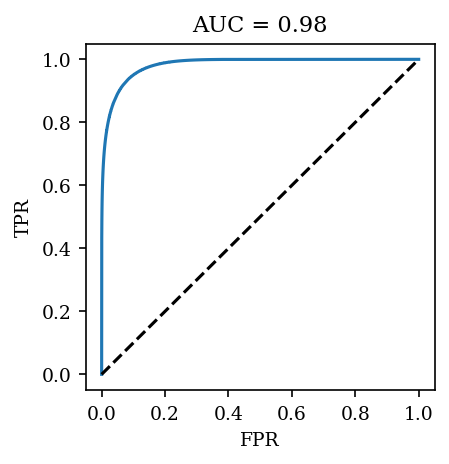

In [15]:
plt.rc('font', family='serif', size=9)
from sklearn import metrics

fpr, tpr, thresh = metrics.roc_curve(flat_targets, flat_predictions)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(3,3), dpi=150)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], c='k', ls='--')
plt.title("AUC = {:.2f}".format(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")

$\textbf{[Figure 6]}$ The ROC curve, which plots the False Positive Rate (FPR) against the True Positive Rate (TPR), along with the Area Under the Curve (AUC) metric, demonstrates that our model performs effectively when treating the task as a binary classification problem.

### This demo ends with an evaluation of the model's performance from an astrophysical interpretation perspective.

One metric to evaluate the performance of the model is to examine the topological distribution of the ionized bubbles, as mentioned earlier. From the binary maps, we derived the bubble size distribution (BSD) using a Monte Carlo approach to identify the locations and sizes of ionized bubbles. Figure 7 shows the BSD results for various test samples (different cases). In each case, the predicted BSD aligns closely with the ground truth, indicating that the model accurately captures the bubble size distribution. This suggests the model’s robustness in predicting topological features of the ionized regions.

In [16]:
def evaluate_test_sample_for_BSD(model, image_path, mask_path, device, pattern):
    images = []
    predictions = []
    targets = []

    for file in sorted(list(glob.glob(os.path.join(image_path, pattern)))):
        images.append(np.load(file))
        mask_file = os.path.join(mask_path, os.path.basename(str(file)).replace('.npy', '_mask.npy'))
        targets.append(np.load(mask_file))
    images = torch.from_numpy(np.array(images)[:, None, ...])
    targets = np.array(targets)

    images = images.to(device, dtype=torch.float32, memory_format=torch.channels_last)
    model = model.to(device, dtype=torch.float32, memory_format=torch.channels_last)

    outputs = model(images)

    predictions = (outputs > 0.5).float()

    images = images.cpu().detach().numpy().squeeze()
    predictions = predictions.cpu().detach().numpy().squeeze()

    return images, predictions, targets

In [17]:
def derive_bubble_size(field, N_pnts, l_box=200):
    '''
        Derive bubble size distribution from the given ionization field
        
        Parameters:
            field: 2D array
                The ionization field to look for the bubble size distribution
            N_pnts: int
                The number of points placed at ionized field for Monte Carlo inference of bubble size
            l_box: float
                The size of box in Mpc
                
        Returns:
            field: array
                The ionized field with (n, n) shape; 0 and 1 indicate neutral and ionized phases, repectively
            R_bubble: array
                The estimated sizes of bubbles
    '''
    
    n = field.shape[0]
    x_box = np.arange(n) / n * l_box
    y_box = np.arange(n) / n * l_box
    x_bin, y_bin = np.meshgrid(x_box, y_box)

    field = np.where(field >= 0.5, 1, 0)
    
    idx = np.where(field == 1)
    if(len(idx[0]) != 0):
        x_HII = x_bin[idx]
        y_HII = y_bin[idx]

        idx_rand = np.int32(np.random.rand(N_pnts) * x_HII.size)
        x_rand = x_HII[idx_rand]
        y_rand = y_HII[idx_rand]
        phi_rand = np.random.rand(N_pnts) * 2*np.pi

        x_coord = np.int32(x_rand / l_box * n)
        y_coord = np.int32(y_rand / l_box * n)

        r = np.arange(2*n)
        R_bubble = []
        for x_c, y_c, phi_r in zip(x_coord, y_coord, phi_rand):
            x_search = x_c + np.int32(r*np.cos(phi_r))
            y_search = y_c + np.int32(r*np.sin(phi_r))
            idx = np.where((x_search >= 0) * (x_search < n) * (y_search >=0) * (y_search < n))[0]
            x_search = x_search[idx]
            y_search = y_search[idx]

            idx_r = np.where(field[y_search, x_search] == 0)[0]
            if(len(idx_r) !=0):
                idx_r = idx_r[0]
            else:
                idx_r = -1
            R = np.sqrt((x_search[idx_r] - x_c)**2 + (y_search[idx_r] - y_c)**2) * l_box / n
            R_bubble.append(R)
        R_bubble = np.array(R_bubble)
    else:
        R_bubble = None
    
    return R_bubble

In [18]:
def compute_BSD(R_bubble, R_min=0.1, R_max=30, nbins=10):
    N_bubble, R_bin = np.histogram(R_bubble, bins=np.logspace(np.log10(R_min), np.log10(R_max), num=nbins))
    R_bin = (R_bin[:-1] + R_bin[1:])/2
    PDF = R_bin * N_bubble
    PDF /= np.sum(PDF * np.diff(R_bin)[0])
    
    return R_bin, PDF

In [19]:
model_id = 929
idx_redshift = [50, 190, 250]
dir_img_test = DATA_PATH['img_test2']
dir_mask_test = DATA_PATH['mask_test2']

PDF_mask, PDF_pred, x_HII_dict = {}, {}, {}
N_pnts = int(1e4)
for i, idx_ in enumerate(idx_redshift):
    PDF_mask_list = []
    PDF_pred_list = []
    for j in range(40):
        pattern = "model{:04d}*{:03d}*".format(model_id, j+1)
        images, mask_pred, mask_true = evaluate_test_sample_for_BSD(model, dir_img_test, dir_mask_test, device, pattern)
        
        R_mask = derive_bubble_size(1-mask_true[idx_,4:-4,4:-4], N_pnts, l_box=500)
        R_predict = derive_bubble_size(1-mask_pred[idx_,4:-4,4:-4], N_pnts, l_box=500)

        R_bin, PDF_ = compute_BSD(R_mask, R_min=1, R_max=1000, nbins=20)
        PDF_mask_list.append(PDF_)
        R_bin, PDF_ = compute_BSD(R_predict, R_min=1, R_max=1000, nbins=20)
        PDF_pred_list.append(PDF_)
        
    PDF_mask[i] = np.array(PDF_mask_list)
    PDF_pred[i] = np.array(PDF_pred_list)

    x_HII = 1 - np.mean(mask_true[idx_,4:-4,4:-4])
    x_HII_dict[i] = x_HII

In [ ]:
plt.rc('font', family='serif', size=9)
colors = ['#FFA500', '#4876FF', '#CD5C5C', '#43CD80', '#27408B']
fig = plt.figure(figsize=(5,3), dpi=150)
ax = fig.add_subplot(1,1,1)
for i in range(3):
    PDF_mask_mean = np.mean(PDF_mask[i], axis=0)
    PDF_pred_mean = np.mean(PDF_pred[i], axis=0)
    PDF_pred_std = np.std(PDF_pred[i], axis=0)
    ax.plot(R_bin, PDF_mask_mean, c='k', ls='--', lw=3)
    ax.plot(R_bin, PDF_pred_mean, c=colors[i], label=r'Case {} (x={:.2f})'.format(i+1, x_HII_dict[i]))
    ax.fill_between(
        R_bin,
        PDF_pred_mean - PDF_pred_std,
        PDF_pred_mean + PDF_pred_std,
        alpha=0.35,
        facecolor=colors[i],
    )
ax.set_title("Bubble Size Distribution")
ax.set_xscale('log')
ax.set_ylim(-0.01,0.5)
ax.set_xlabel(r'R (Mpc)')
ax.set_ylabel('R dn/dR')
    
plt.legend(loc='upper left', fontsize=9)

$\textbf{[Figure 7]}$ Bubble Size Distribution (BSD) for various cases. The black dashed lines represent the ground truth for each case. For every case, 40 distinct test samples were generated using augmentation techniques like rotation and translation, all of which share the same ground truth BSD. The solid lines and shaded regions depict the mean and standard deviation of the predicted BSD. In all cases, the predictions closely align with the ground truth, suggesting that the $\texttt{U-net}$ deep learning model is highly effective in extracting topological information observed by our instrument.